# General Adversarial Networks (GANs)

Basic idea behind GANs is that there are two competing neural networks (generator network and discriminator network) that work towards opposing goals. The goal of the generator network is to fool the discriminator network into believing that the data generated by the generator network is real.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
tf.__version__

'2.3.1'

In [3]:
def get_y(x):
    return 10 + x*x


def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

In [4]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(16, input_shape=(2,)))
    
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(16))
    
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(2))
    
    return model

In [5]:
generator = make_generator_model()

noise = tf.random.uniform(shape=[1,2],minval = -1., maxval = 1.)
generated_image = generator(noise, training=False)
generated_image

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.01849531,  0.6506506 ]], dtype=float32)>

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(16, input_shape=(2,)))
    
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(16))
    
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(2))
    
    model.add(layers.Dense(1))
    
    return model

In [7]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.13418736]], shape=(1, 1), dtype=float32)


In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 100000
noise_dim = 2
num_examples_to_generate = 500

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.uniform(shape=[num_examples_to_generate, noise_dim], minval = -1., maxval = 1.)

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.uniform(shape=[BATCH_SIZE, noise_dim], minval = -1., maxval = 1.)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [23]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_vec = []
        disc_loss_vec = []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_vec.append(gen_loss)
            disc_loss_vec.append(disc_loss)
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        # if (epoch + 1) % 15 == 0:
        #     checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec and gen loss is {} and disc loss is {}'.format(epoch + 1,
                                                                                           time.time()-start,
                                                                                           np.mean(gen_loss_vec),
                                                                                           np.mean(disc_loss_vec)))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [24]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,4))
    plt.scatter(dataset[0:500,0], dataset[0:500,1], label = 'real data')
    plt.scatter(predictions[:,0], predictions[:,1], label = 'fake data')
    plt.legend()
    #plt.xlim(-50,50)
    #plt.ylim(0,3000)
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [25]:
dataset = sample_data(n=10000, scale=100)

BUFFER_SIZE = 10000
BATCH_SIZE = 1000

train_data = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [32]:
train(train_data, EPOCHS)

KeyboardInterrupt: 

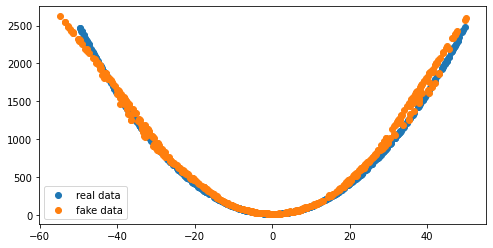

In [33]:
seed = tf.random.uniform(shape=[num_examples_to_generate, noise_dim], minval = -1., maxval = 1.)
generate_and_save_images(generator,
                           1,
                           seed)